# E3 (DR): 1D bimodal → bimodal optimal transport with H‑PID (analytic score)

This notebook implements a **Demand-Response** inspired toy problem in **1D**:

- Initial temperature distribution $p^{(in)}$ is a **2‑mode Gaussian mixture** (occupied / unoccupied).
- Target distribution $p^{(tar)}$ is another **2‑mode Gaussian mixture**.
- We compute the H‑PID / guided bridge score field **analytically** (Appendix **A.1**) and
  simulate the controlled SDE starting from **samples of $p^{(in)}$** (Appendix **C.3**).

Outputs (saved under `test/figs/e3_dr_1d/`):
1. Initial vs. target density curves.
2. Histogram snapshots along the bridge.
3. Control field $u_t^{(*)}(x;z)$ for two representative starts $z$.
4. Sample trajectories (small batch) + terminal fit to the target.


In [1]:
# -----------------------------------------------------------------------------
# Imports and module wiring (relative; no hard-coded absolute paths)
# -----------------------------------------------------------------------------
import sys
from pathlib import Path
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

# Make `import guided_continuous` work when running from guided_continuous/test/
HERE = Path().resolve()
ROOT = HERE.parents[1]  # .../guided_continuous
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from guided_continuous import (
    PWCProtocol, ContinuousCoeffs, GaussianMixture, GuidedField, TimeDomain
)

# Internal helpers from the simulator (used to build a breakpoint-aligned grid)
from guided_continuous.sde import _build_break_aligned_grid, _make_break_set, _time_eval_right_limit

device = torch.device("cpu")
dtype  = torch.float64
torch.set_default_dtype(dtype)

print("ROOT:", ROOT)
print("device:", device, "dtype:", dtype)

from torch import Tensor
from guided_continuous.guided_field import _as_batch_time


ROOT: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks
device: cpu dtype: torch.float64


## Problem specification (DR toy model)

We interpret the two mixture components as “occupied” and “unoccupied” buildings.

- After a curtailment episode the population temperature distribution is **warmer**: $p^{(in)}$.
- During recovery we steer the ensemble to a **cooler** target: $p^{(tar)}$.

Both are 2‑component Gaussian mixtures with the **same weights** (fixed population fractions).

In [2]:
# -----------------------------------------------------------------------------
# DR toy distributions: p_in (warm) and p_tar (cool)  -- both 2-mode GMM in 1D
# -----------------------------------------------------------------------------
# Mixture weights (occupied / unoccupied fractions)
pi = torch.tensor([0.60, 0.40], dtype=dtype, device=device)

# Initial (post-curtailment) distribution: warmer
m_in  = torch.tensor([[1.0], [3.0]], dtype=dtype, device=device)       # means
s_in  = torch.tensor([0.30, 0.40], dtype=dtype, device=device)         # std dev

# Target (post-recovery) distribution: cooler
m_tar = torch.tensor([[0.0], [2.0]], dtype=dtype, device=device)
s_tar = torch.tensor([0.25, 0.35], dtype=dtype, device=device)

def cov_from_std(s: torch.Tensor) -> torch.Tensor:
    # s: (K,) -> covs: (K,1,1)
    return (s**2).reshape(-1,1,1)

gm_in  = GaussianMixture(weights=pi, means=m_in,  covs=cov_from_std(s_in))
gm_tar = GaussianMixture(weights=pi, means=m_tar, covs=cov_from_std(s_tar))

print("gm_in :", gm_in.weights, gm_in.means.flatten().tolist(), s_in.tolist())
print("gm_tar:", gm_tar.weights, gm_tar.means.flatten().tolist(), s_tar.tolist())


gm_in : tensor([0.6000, 0.4000]) [1.0, 3.0] [0.3, 0.4]
gm_tar: tensor([0.6000, 0.4000]) [0.0, 2.0] [0.25, 0.35]


## H‑PID / guided setting

We use the harmonic/guided quadratic running potential with **PWC** protocol on $t\in[0,1]$.

For this illustrative example we keep the guidance center $\nu_t\equiv 0$ and use a mild,
piecewise-constant stiffness $\beta_t$ (you can make it more/less aggressive later).

In [3]:
# -----------------------------------------------------------------------------
# Protocol: piecewise-constant beta(t) and nu(t) in 1D
# -----------------------------------------------------------------------------
time_domain = TimeDomain(eps=1e-3)  # interior time policy

breaks = torch.tensor([0.0, 0.25, 0.50, 0.75, 1.0], dtype=dtype, device=device)

# Mild stiffness (same on each interval for now)
beta_vals = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=dtype, device=device).reshape(-1,)

# Center of quadratic potential (can be used as a "setpoint schedule")
nu_vals = torch.zeros((4, 1), dtype=dtype, device=device)

beta = PWCProtocol(breaks=breaks, values=beta_vals, time_domain=time_domain)
nu   = PWCProtocol(breaks=breaks, values=nu_vals,   time_domain=time_domain)

coeffs = ContinuousCoeffs(beta=beta, nu=nu, time_domain=time_domain)

# Build the analytic field for the *target* mixture; u_star will be modified for random starts (Appendix C.3)
field = GuidedField(coeffs=coeffs, target=gm_tar, time_domain=time_domain)

print("breaks:", breaks.tolist())
print("a_plus_1:", float(coeffs.a_plus_1))


breaks: [0.0, 0.25, 0.5, 0.75, 1.0]
a_plus_1: 1.3130352854993315


## Helpers: sampling and density evaluation

In [4]:
# -----------------------------------------------------------------------------
# Helpers: sample from a 1D Gaussian mixture and evaluate its pdf on a grid
# -----------------------------------------------------------------------------
def sample_gmm_1d(gm: GaussianMixture, B: int, *, seed: int = 0):
    """Return x0 ~ gm and component labels k (both torch)."""
    gen = torch.Generator(device=device)
    gen.manual_seed(int(seed))
    K = gm.K

    comp = torch.multinomial(gm.weights, num_samples=B, replacement=True, generator=gen)  # (B,)
    means = gm.means[comp, 0]  # (B,)
    vars_  = gm.covs[comp, 0, 0]
    x = means + torch.sqrt(vars_) * torch.randn((B,), dtype=dtype, device=device, generator=gen)
    return x.reshape(B,1), comp

def gmm_pdf_1d(x: np.ndarray, gm: GaussianMixture) -> np.ndarray:
    """PDF of a 1D Gaussian mixture evaluated at numpy array x."""
    w = gm.weights.detach().cpu().numpy()
    m = gm.means.detach().cpu().numpy().reshape(-1)
    v = gm.covs.detach().cpu().numpy().reshape(-1)
    out = np.zeros_like(x, dtype=float)
    for k in range(len(w)):
        out += w[k] * (1.0/np.sqrt(2*np.pi*v[k])) * np.exp(-0.5*(x-m[k])**2 / v[k])
    return out

FIG_DIR = Path("figs/e3_dr_1d")
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("FIG_DIR:", FIG_DIR.resolve())


FIG_DIR: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks/guided_continuous/test/figs/e3_dr_1d


## Figure 1: initial vs target density

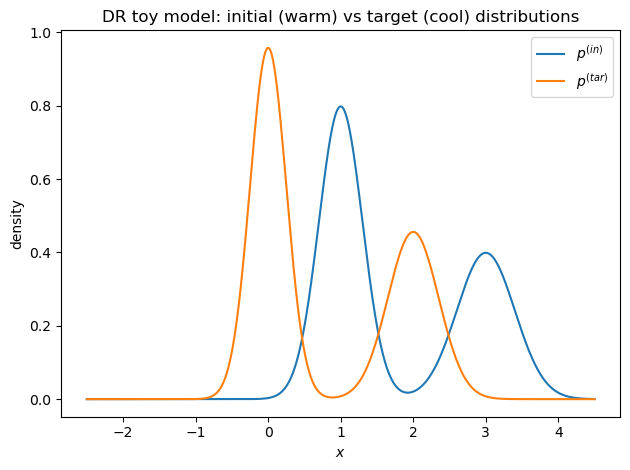

In [5]:
# -----------------------------------------------------------------------------
# Fig 1: density curves
# -----------------------------------------------------------------------------
xgrid = np.linspace(-2.5, 4.5, 800)
pin  = gmm_pdf_1d(xgrid, gm_in)
ptar = gmm_pdf_1d(xgrid, gm_tar)

plt.figure()
plt.plot(xgrid, pin,  label=r"$p^{(in)}$")
plt.plot(xgrid, ptar, label=r"$p^{(tar)}$")
plt.xlabel(r"$x$")
plt.ylabel("density")
plt.title("DR toy model: initial (warm) vs target (cool) distributions")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "e3_fig1_pin_ptar.pdf")
plt.show()


## Appendix C.3: random initial condition via an $x_0$-dependent score

Appendix **A.1** provides an analytic expression for $u_t^{(*)}(x)$ when the start is a **Dirac** at 0.

Appendix **C.3** explains how to handle a deterministic nonzero start $X_0=z$:
the effect is captured (for the analytic objects used in A.1) by a simple shift
in the forward linear term at $t=1$, which in this implementation translates to
a **batch-dependent shift** of `theta_plus_1` by `a_plus_1 * z`.

Below we implement a vectorized drift
\[
u_t^{(*)}(x;z)\quad\text{for batched }(x,z),
\]
and then simulate from samples $z\sim p^{(in)}$ with $X_0=z$.

In [17]:
# -----------------------------------------------------------------------------
# Start-conditioned control u*_t(x; x0=z) using *validated* GuidedField.yhat()
#
# We avoid re-implementing yhat. Instead we exploit:
#   mu(t,x) = alpha_t x + dbar_t,  alpha_t = b^-_t / K_t
# and Appendix C terminal θ⁺ shift implies:
#   mu_z(t,x) = mu(t,x) - (a1p / K_t) z
#
# Since alpha_t = b^-_t / K_t, we can realize this by shifting x:
#   x_tilde = x - (a1p / b^-_t) z
# Then:
#   mu(t, x_tilde) = alpha_t x_tilde + dbar_t
#                 = alpha_t x + dbar_t - alpha_t (a1p/b^-_t) z
#                 = mu(t,x) - (a1p/K_t) z
#
# Therefore:
#   yhat(t,x;z) = field.yhat(t, x_tilde)
# and the start-conditioned control is:
#   u*(t,x;z) = b^-_t ( yhat(t,x;z) - Upsilon(t,x) )
# -----------------------------------------------------------------------------

from torch import Tensor
import torch


def _as_batch_time_local(t: Tensor, B: int, dtype: torch.dtype, device: torch.device) -> Tensor:
    """Local version (matches guided_field._as_batch_time semantics)."""
    tt = torch.as_tensor(t, dtype=dtype, device=device)
    if tt.ndim == 0:
        return tt.expand(B)
    if tt.ndim == 1 and tt.numel() == 1:
        return tt.expand(B)
    if tt.ndim == 1 and tt.numel() == B:
        return tt
    raise ValueError(f"t must be scalar or (B,), got shape {tuple(tt.shape)} with B={B}")


def yhat_with_start(t: Tensor, x: Tensor, z: Tensor, *, field: GuidedField) -> Tensor:
    """
    Compute yhat(t,x;z) for deterministic start x0=z using the validated field.yhat().
    """
    if x.ndim != 2 or z.ndim != 2:
        raise ValueError("x and z must be (B,d)")
    if x.shape != z.shape:
        raise ValueError("x and z must have the same shape (B,d)")

    B, _ = x.shape
    tt = _as_batch_time_local(t, B, x.dtype, x.device)
    tt = field.time_domain.clamp(tt)

    # Scalars per batch
    bm = field.coeffs.b_minus(tt)          # (B,)
    a1p = field.coeffs.a_plus_1            # scalar (0-d tensor or python float)

    if not torch.is_tensor(a1p):
        a1p = torch.as_tensor(a1p, dtype=x.dtype, device=x.device)
    else:
        a1p = a1p.to(dtype=x.dtype, device=x.device)
    if a1p.ndim != 0:
        a1p = a1p.reshape(())

    # Avoid division by zero (bm can be small very near endpoints)
    bm_safe = torch.clamp(bm, min=1e-300)

    # Exact input shift that induces mu-shift corresponding to θ1⁺(z)=θ1⁺+a1p z
    x_tilde = x - (a1p / bm_safe).unsqueeze(-1) * z  # (B,d)

    # Reuse validated mixture algebra
    return field.yhat(tt, x_tilde)  # (B,d)


def u_star_with_start(t: Tensor, x: Tensor, z: Tensor, *, field: GuidedField) -> Tensor:
    """
    Start-conditioned u*(t,x;z) using:
        u = b^-_t ( yhat(t,x;z) - Upsilon(t,x) )
    """
    if x.ndim != 2 or z.ndim != 2:
        raise ValueError("x and z must be (B,d)")
    if x.shape != z.shape:
        raise ValueError("x and z must have the same shape (B,d)")

    B, _ = x.shape
    tt = _as_batch_time_local(t, B, x.dtype, x.device)
    tt = field.time_domain.clamp(tt)

    b = field.coeffs.b_minus(tt).unsqueeze(-1)          # (B,1)
    yhat_z = yhat_with_start(tt, x, z, field=field)     # (B,d)
    ups = field.Upsilon(tt, x)                          # (B,d)  NOTE: evaluated at true x

    return b * (yhat_z - ups)


# quick shape sanity check
B_test = 5
x0_test, _ = sample_gmm_1d(gm_in, B_test, seed=123)
x_test = x0_test.clone()
print("u shape:", u_star_with_start(torch.tensor(0.5, dtype=dtype), x_test, x0_test, field=field).shape)


u shape: torch.Size([5, 1])


## Simulate the bridge from $p^{(in)}$ to $p^{(tar)}$

We run Euler–Maruyama with a **breakpoint-aligned** time grid (same convention as E1/E2),
starting from $X_0=z$ where $z\sim p^{(in)}$.

In [18]:
# -----------------------------------------------------------------------------
# EM simulation with user-provided initial states x0 ~ p_in
# We record histogram snapshots at a few times for plotting.
# -----------------------------------------------------------------------------
def simulate_em_with_random_start(
    *,
    field: GuidedField,
    gm_in: GaussianMixture,
    B: int = 5000,
    n_steps: int = 1000,
    seed: int = 0,
    snap_times=(0.25, 0.50, 0.75, 0.999),
):
    # sample initial states
    x0, labels = sample_gmm_1d(gm_in, B, seed=seed)
    x = x0.clone()

    # time grid with breakpoints
    times = _build_break_aligned_grid(
        n_steps=n_steps,
        breaks=field.coeffs.breaks,
        dtype=dtype,
        device=device,
        time_domain=field.time_domain,
    )
    bset = _make_break_set(field.coeffs.breaks, dtype=dtype, device=device, time_domain=field.time_domain)
    dt_vec = times[1:] - times[:-1]

    # map snapshot times to nearest indices
    snap_times = list(snap_times)
    snap_idx = {}
    for st in snap_times:
        st_clamped = float(field.time_domain.clamp(torch.tensor(st, dtype=dtype)).item())
        idx = int(torch.argmin(torch.abs(times - st_clamped)).item())
        snap_idx[idx] = st

    snaps = {}
    gen = torch.Generator(device=device); gen.manual_seed(int(seed))

    for i in range(times.numel() - 1):
        t = times[i]
        dt = dt_vec[i]
        sqrt_dt = torch.sqrt(dt)

        t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device, post_jump_eps=1e-12)

        drift = u_star_with_start(t_eval, x, x0, field=field)
        noise = torch.randn((B, 1), dtype=dtype, device=device, generator=gen)
        x = x + drift * dt + sqrt_dt * noise

        if i in snap_idx:
            snaps[float(times[i].item())] = x.detach().cpu().numpy().reshape(-1)

    # always store terminal
    snaps[float(times[-1].item())] = x.detach().cpu().numpy().reshape(-1)

    return times.detach().cpu().numpy(), x0.detach().cpu().numpy().reshape(-1), labels.detach().cpu().numpy(), snaps

B = 5000
times_np, x0_np, lab_np, snaps = simulate_em_with_random_start(
    field=field, gm_in=gm_in, B=B, n_steps=1000, seed=7, snap_times=(0.25,0.5,0.75)
)

print("Recorded snapshots at t ~", sorted(snaps.keys())[:5], "...", "and terminal.")


Recorded snapshots at t ~ [0.25, 0.5, 0.75, 0.999] ... and terminal.


In [20]:
# -----------------------------------------------------------------------------
# EM simulation with DETERMINISTIC start x0 = z (delta-function, z ≠ 0)
#
# DEBUG TEST: Appendix C.1 guarantees that for x0 = z (fixed), the controlled
# SDE with the θ⁺-shifted score still transports to the SAME p^(tar) at t=1.
# Any mismatch in mode weights here is a bug in the shift, not in the
# averaging over p^(in).
# -----------------------------------------------------------------------------
z_start = 1.5  # ← nonzero deterministic start; change freely

def simulate_em_deterministic_start(
    *,
    field: GuidedField,
    z: float,
    B: int = 10000,
    n_steps: int = 2000,
    seed: int = 0,
    snap_times=(0.25, 0.50, 0.75, 0.999),
):
    # ALL particles start at the same deterministic z
    x0 = torch.full((B, 1), z, dtype=dtype, device=device)
    x  = x0.clone()

    # time grid with breakpoints
    times = _build_break_aligned_grid(
        n_steps=n_steps,
        breaks=field.coeffs.breaks,
        dtype=dtype,
        device=device,
        time_domain=field.time_domain,
    )
    bset = _make_break_set(field.coeffs.breaks, dtype=dtype, device=device, time_domain=field.time_domain)
    dt_vec = times[1:] - times[:-1]

    # map snapshot times to nearest indices
    snap_times = list(snap_times)
    snap_idx = {}
    for st in snap_times:
        st_clamped = float(field.time_domain.clamp(torch.tensor(st, dtype=dtype)).item())
        idx = int(torch.argmin(torch.abs(times - st_clamped)).item())
        snap_idx[idx] = st

    snaps = {}
    gen = torch.Generator(device=device); gen.manual_seed(int(seed))

    for i in range(times.numel() - 1):
        t = times[i]
        dt = dt_vec[i]
        sqrt_dt = torch.sqrt(dt)

        t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device, post_jump_eps=1e-12)

        drift = u_star_with_start(t_eval, x, x0, field=field)
        noise = torch.randn((B, 1), dtype=dtype, device=device, generator=gen)
        x = x + drift * dt + sqrt_dt * noise

        if i in snap_idx:
            snaps[float(times[i].item())] = x.detach().cpu().numpy().reshape(-1)

    # always store terminal
    snaps[float(times[-1].item())] = x.detach().cpu().numpy().reshape(-1)

    return times.detach().cpu().numpy(), x0.detach().cpu().numpy().reshape(-1), \
           np.zeros(B, dtype=int), snaps  # labels=0 (dummy)

B = 10000
times_np, x0_np, lab_np, snaps = simulate_em_deterministic_start(
    field=field, z=z_start, B=B, n_steps=8000, seed=7, snap_times=(0.25, 0.5, 0.75)
)

print(f"Deterministic start z = {z_start}")
print("Recorded snapshots at t ~", sorted(snaps.keys())[:5], "...", "and terminal.")

Deterministic start z = 1.5
Recorded snapshots at t ~ [0.25, 0.5, 0.75, 0.999] ... and terminal.


In [22]:
# -----------------------------------------------------------------------------
# COORDINATE-SHIFT approach (exact, bypasses the buggy θ⁺-shift rule).
#
# For deterministic start x₀ = z, define:
#   - shifted guidance:  ν̃ = ν − z
#   - shifted target:    m̃_k = m_k − z  (same weights & covariances)
# Build a NEW field with these, simulate the standard x₀=0 bridge, then
# translate all samples by +z.
#
# The scalar coefficients (a±, b⁻, c⁻) depend only on β and are UNCHANGED.
# Only the θ-trajectories (which depend on ν) are recomputed automatically
# by the ContinuousCoeffs constructor.
# -----------------------------------------------------------------------------
z_start = 1.5  # deterministic nonzero start

z_vec = torch.tensor([[z_start]], dtype=dtype, device=device)  # (1,d)

# --- shifted target ---
gm_tar_shifted = GaussianMixture(
    weights=gm_tar.weights.clone(),
    means=gm_tar.means - z_vec,          # m̃_k = m_k − z
    covs=gm_tar.covs.clone(),
)

# --- shifted guidance protocol ---
nu_shifted_vals = nu_vals - z_vec.expand_as(nu_vals)   # ν̃ = ν − z  (nu_vals from Cell 5)
nu_shifted = PWCProtocol(breaks=breaks, values=nu_shifted_vals, time_domain=time_domain)

# --- rebuild coefficients & field (only θ± change; a±,b⁻,c⁻ are reused internally) ---
coeffs_shifted = ContinuousCoeffs(beta=beta, nu=nu_shifted, time_domain=time_domain)
field_shifted  = GuidedField(coeffs=coeffs_shifted, target=gm_tar_shifted, time_domain=time_domain)

# --- simulate from x₀=0 with the STANDARD (validated) u_star ---
def simulate_em_coordshift(
    *,
    field: GuidedField,
    z: float,
    B: int = 10000,
    n_steps: int = 2000,
    seed: int = 0,
    snap_times=(0.25, 0.50, 0.75, 0.999),
):
    x = torch.zeros((B, 1), dtype=dtype, device=device)   # x₀ = 0

    times = _build_break_aligned_grid(
        n_steps=n_steps,
        breaks=field.coeffs.breaks,
        dtype=dtype, device=device,
        time_domain=field.time_domain,
    )
    bset = _make_break_set(field.coeffs.breaks, dtype=dtype, device=device,
                           time_domain=field.time_domain)
    dt_vec = times[1:] - times[:-1]

    snap_times = list(snap_times)
    snap_idx = {}
    for st in snap_times:
        st_c = float(field.time_domain.clamp(torch.tensor(st, dtype=dtype)).item())
        idx = int(torch.argmin(torch.abs(times - st_c)).item())
        snap_idx[idx] = st

    snaps = {}
    gen = torch.Generator(device=device); gen.manual_seed(int(seed))

    for i in range(times.numel() - 1):
        t = times[i]
        dt = dt_vec[i]
        t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device, post_jump_eps=1e-12)

        drift = field.u_star(t_eval, x)          # ← standard z=0 API
        noise = torch.randn((B, 1), dtype=dtype, device=device, generator=gen)
        x = x + drift * dt + torch.sqrt(dt) * noise

        if i in snap_idx:
            snaps[float(times[i].item())] = (x + z).detach().cpu().numpy().reshape(-1)

    snaps[float(times[-1].item())] = (x + z).detach().cpu().numpy().reshape(-1)

    x0_dummy = np.full(B, z)
    return times.detach().cpu().numpy(), x0_dummy, np.zeros(B, dtype=int), snaps

B = 5000
times_np, x0_np, lab_np, snaps = simulate_em_coordshift(
    field=field_shifted, z=z_start, B=B, n_steps=1000, seed=7,
    snap_times=(0.25, 0.5, 0.75),
)

print(f"Coordinate-shift approach, z = {z_start}")
print("Recorded snapshots at t ~", sorted(snaps.keys())[:5], "...", "and terminal.")

Coordinate-shift approach, z = 1.5
Recorded snapshots at t ~ [0.25, 0.5, 0.75, 0.999] ... and terminal.


## Figure 2: distribution snapshots along the bridge

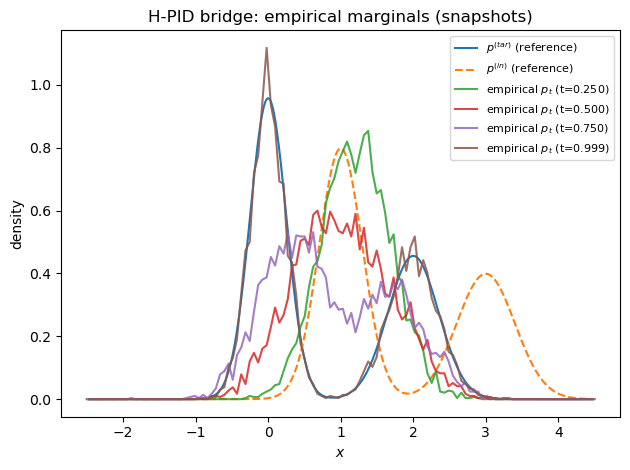

In [23]:
# -----------------------------------------------------------------------------
# Fig 2: histogram snapshots
# -----------------------------------------------------------------------------
xgrid = np.linspace(-2.5, 4.5, 800)
ptar = gmm_pdf_1d(xgrid, gm_tar)
pin  = gmm_pdf_1d(xgrid, gm_in)

plt.figure()
plt.plot(xgrid, ptar, label=r"$p^{(tar)}$ (reference)")
plt.plot(xgrid, pin,  '--', label=r"$p^{(in)}$ (reference)")

# snapshot histograms
for t_key in sorted(snaps.keys()):
    data = snaps[t_key]
    # use a light density estimate via histogram
    hist, edges = np.histogram(data, bins=120, range=(xgrid.min(), xgrid.max()), density=True)
    centers = 0.5*(edges[:-1]+edges[1:])
    plt.plot(centers, hist, label=fr"empirical $p_t$ (t={t_key:.3f})", alpha=0.85)

plt.xlabel(r"$x$")
plt.ylabel("density")
plt.title("H‑PID bridge: empirical marginals (snapshots)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(FIG_DIR / "e3_fig2_snapshots.pdf")
plt.show()


## Figure 3: control field dependence on the start $z$

For random starts $z\sim p^{(in)}$, the drift depends on $z$.
To visualize this dependence we plot $u_t^{(*)}(x;z)$ for two representative values of $z$:
the two initial mode means.

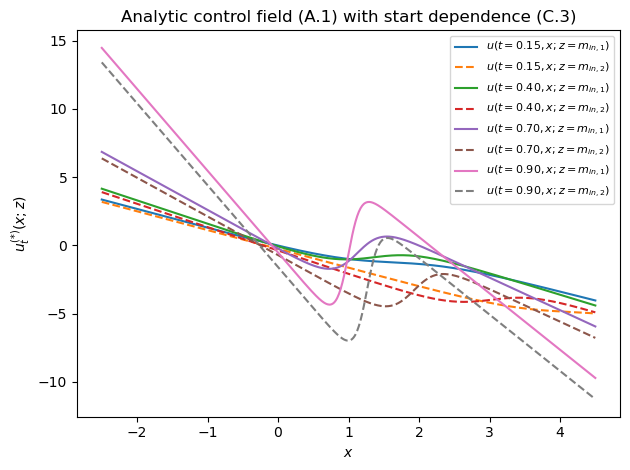

In [9]:
# -----------------------------------------------------------------------------
# Fig 3: u_t(x;z) curves for z=m_in[0] and z=m_in[1] at a few times
# -----------------------------------------------------------------------------
xs = torch.linspace(-2.5, 4.5, 600, dtype=dtype, device=device).reshape(-1,1)
z1 = torch.full_like(xs, float(m_in[0,0].item()))
z2 = torch.full_like(xs, float(m_in[1,0].item()))

times_to_plot = [0.15, 0.40, 0.70, 0.90]

plt.figure()
for t0 in times_to_plot:
    u1 = u_star_with_start(torch.tensor(t0, dtype=dtype), xs, z1, field=field).detach().cpu().numpy().reshape(-1)
    u2 = u_star_with_start(torch.tensor(t0, dtype=dtype), xs, z2, field=field).detach().cpu().numpy().reshape(-1)
    plt.plot(xs.cpu().numpy().reshape(-1), u1, label=fr"$u(t={t0:.2f},x; z=m_{{in,1}})$")
    plt.plot(xs.cpu().numpy().reshape(-1), u2, '--', label=fr"$u(t={t0:.2f},x; z=m_{{in,2}})$")

plt.xlabel(r"$x$")
plt.ylabel(r"$u_t^{(*)}(x;z)$")
plt.title("Analytic control field (A.1) with start dependence (C.3)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(FIG_DIR / "e3_fig3_control_field.pdf")
plt.show()


## Figure 4: sample trajectories (small batch)

We run a smaller simulation (fewer particles, fewer steps) and plot a handful of paths,
colored by the initial mixture component.

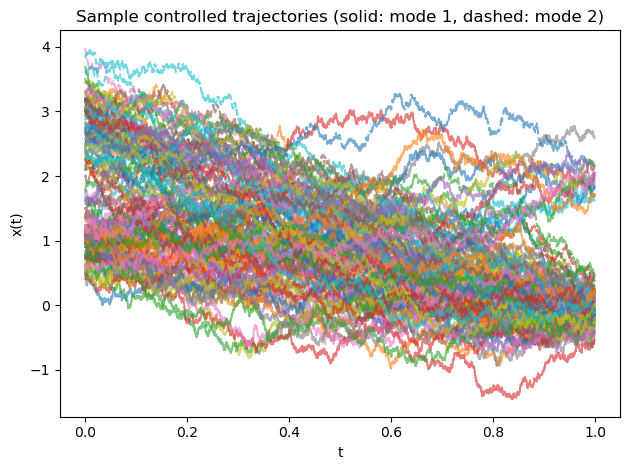

In [10]:
# -----------------------------------------------------------------------------
# Small-batch trajectories for visualization
# -----------------------------------------------------------------------------
def simulate_paths_small(
    *,
    field: GuidedField,
    gm_in: GaussianMixture,
    B_show: int = 120,
    n_steps: int = 2000,
    seed: int = 1,
):
    x0, labels = sample_gmm_1d(gm_in, B_show, seed=seed)
    x = x0.clone()

    times = _build_break_aligned_grid(
        n_steps=n_steps,
        breaks=field.coeffs.breaks,
        dtype=dtype,
        device=device,
        time_domain=field.time_domain,
    )
    bset = _make_break_set(field.coeffs.breaks, dtype=dtype, device=device, time_domain=field.time_domain)
    dt_vec = times[1:] - times[:-1]

    traj = torch.empty((times.numel(), B_show, 1), dtype=dtype, device=device)
    traj[0] = x

    gen = torch.Generator(device=device); gen.manual_seed(int(seed))

    for i in range(times.numel() - 1):
        t = times[i]
        dt = dt_vec[i]
        sqrt_dt = torch.sqrt(dt)
        t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device, post_jump_eps=1e-12)

        drift = u_star_with_start(t_eval, x, x0, field=field)
        noise = torch.randn((B_show, 1), dtype=dtype, device=device, generator=gen)
        x = x + drift * dt + sqrt_dt * noise
        traj[i+1] = x

    return times.detach().cpu().numpy(), traj.detach().cpu().numpy().squeeze(-1), labels.detach().cpu().numpy()

t_show, traj_show, lab_show = simulate_paths_small(field=field, gm_in=gm_in, B_show=120, n_steps=2500, seed=11)

plt.figure()
for i in range(traj_show.shape[1]):
    style = '-' if lab_show[i] == 0 else '--'
    plt.plot(t_show, traj_show[:, i], style, alpha=0.6)

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Sample controlled trajectories (solid: mode 1, dashed: mode 2)")
plt.tight_layout()
plt.savefig(FIG_DIR / "e3_fig4_trajectories.pdf")
plt.show()


## Terminal validation

We compare the terminal empirical density to $p^{(tar)}$ and report the
empirical mixture responsibilities with respect to the **target** components.

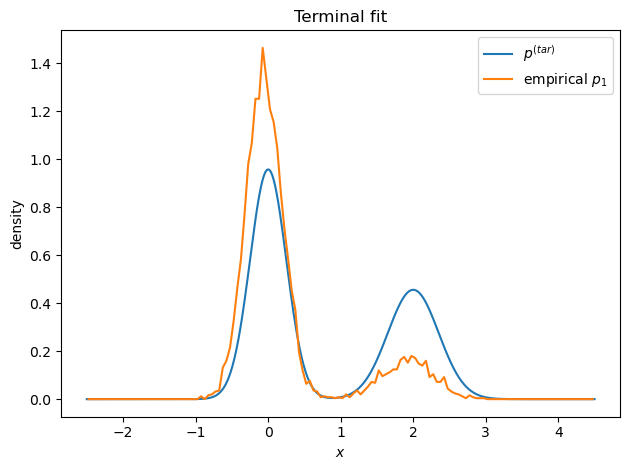

Target weights: [0.6 0.4]
Empirical terminal responsibilities (avg): [0.85322392 0.14677608]
Difference: [ 0.25322392 -0.25322392]


In [11]:
# -----------------------------------------------------------------------------
# Terminal validation: histogram vs target + responsibilities
# -----------------------------------------------------------------------------
xT = snaps[sorted(snaps.keys())[-1]]  # terminal snapshot
hist, edges = np.histogram(xT, bins=140, range=(xgrid.min(), xgrid.max()), density=True)
centers = 0.5*(edges[:-1]+edges[1:])

plt.figure()
plt.plot(xgrid, ptar, label=r"$p^{(tar)}$")
plt.plot(centers, hist, label=r"empirical $p_1$")
plt.xlabel(r"$x$")
plt.ylabel("density")
plt.title("Terminal fit")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "e3_fig5_terminal_fit.pdf")
plt.show()

# Responsibilities w.r.t target components at terminal (soft assignment)
def resp_to_target_components(x: np.ndarray, gm: GaussianMixture) -> np.ndarray:
    w = gm.weights.detach().cpu().numpy()
    m = gm.means.detach().cpu().numpy().reshape(-1)
    v = gm.covs.detach().cpu().numpy().reshape(-1)
    # unnormalized
    r = np.stack([w[k]*(1/np.sqrt(2*np.pi*v[k]))*np.exp(-0.5*(x-m[k])**2/v[k]) for k in range(len(w))], axis=1)
    r = r / (np.sum(r, axis=1, keepdims=True) + 1e-300)
    return r

R = resp_to_target_components(xT, gm_tar)
avg_R = R.mean(axis=0)
print("Target weights:", gm_tar.weights.detach().cpu().numpy())
print("Empirical terminal responsibilities (avg):", avg_R)
print("Difference:", avg_R - gm_tar.weights.detach().cpu().numpy())


In [12]:
print("a_plus_1 =", field.coeffs.a_plus_1)


a_plus_1 = tensor(1.3130)


In [13]:
t0 = torch.tensor(0.5, dtype=dtype, device=device)
x = x0_test.clone()
z = x0_test.clone()

y0 = field.yhat(t0, x)                       # no start conditioning
y1 = yhat_with_start(t0, x, z, field=field)  # with start conditioning
print("Δyhat mean abs:", (y1-y0).abs().mean().item())


Δyhat mean abs: 0.8369523177675553
